## Packets

In [12]:
from GraphSageModel import GNN7L_Sage
from GNNTrain import predict_from_saved_model
from CreateDataset import get_dataset_from_graph
from Paths import PATH_TO_GRAPHS, PATH_TO_MODELS

import heapq
import pandas as pd
import networkx as nx
from tqdm.notebook import tqdm

import torch
import torch_geometric
from torch_geometric.nn.models import GNNExplainer

torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.__version__)
print(device)

1.11.0
cuda


## Prediction

In [36]:
disease_Id = 'C0006142'
graph_path = PATH_TO_GRAPHS + 'grafo_nedbit_' + disease_Id + '.gml'

dataset = get_dataset_from_graph(graph_path, disease_Id).to(device)

[+] Reading graph...ok
[+] Creating dataset...ok
[i] Elapsed time: 40.272


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       154
           1       0.96      0.98      0.97       703
           2       0.88      0.94      0.91       702
           3       0.97      0.88      0.92       703
           4       0.99      1.00      1.00       702

    accuracy                           0.95      2964
   macro avg       0.96      0.96      0.96      2964
weighted avg       0.95      0.95      0.95      2964



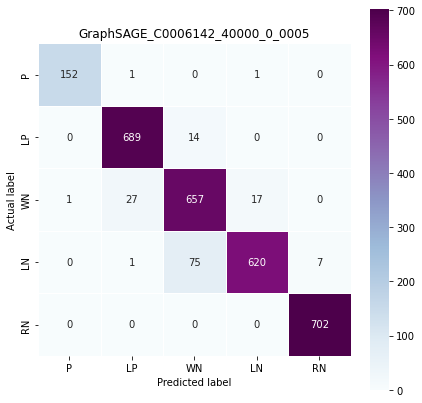

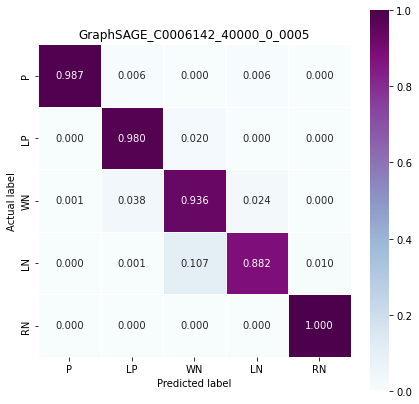

In [37]:
model_name  = 'GraphSAGE_' + disease_Id + '_40000_0_0005'
classes     = ['P', 'LP', 'WN', 'LN', 'RN']

sage_pred_multi, sage_prob_multi, sage_model = predict_from_saved_model(model_name, dataset, classes, save_to_file=False)

# Explainabilty

In [38]:
G = nx.read_gml(graph_path)

In [39]:
# Predicted P(ositive) genes in the test mask
# dictionaries with {gene: prob}
test_P      = {}
overall_LP  = {}

test_mask = dataset.test_mask
test_preds = sage_pred_multi[test_mask]
test_probs = sage_prob_multi[test_mask]

test_nodes = []
i = 0
for node in G.nodes:
    if test_mask[i]:
        test_nodes.append(node)
    if sage_pred_multi[i] == 1 and node not in overall_LP:
        overall_LP[node] = sage_prob_multi[i][1].item() # take probability of class 1 (LP)
    i += 1

i = 0
for node in test_nodes:
    if test_preds[i] == 0 and node not in test_P: #P
        test_P[node] = test_probs[i][0].item() # take probability of class 0 (p)
    i += 1

print('# of predicted positive genes in test mask:', len(test_P))
print('# of predicted overall likely positive genes:', len(overall_LP))

# of predicted positive genes in test mask: 153
# of predicted overall likely positive genes: 4729


In [40]:
k_test_positive_genes   = 16
k_explanation_nodes     = 0.25
k_candidates_for_seed   = 10

top_k_test_P = heapq.nlargest(k_test_positive_genes, test_P, key=test_P.get)

# list of positive genes indexes in test_mask
top_k_test_P_idx = []

for node in top_k_test_P:
    i = 0
    for n in G.nodes:
        if node == n:
            top_k_test_P_idx.append(i)
            break
        i += 1

edge_index = dataset.edge_index

# dict to store for each index the number of nodes (pos 0)
# and edges (pos 1) in the subgraph
subg_numnodes_d = {}

for i in top_k_test_P_idx:
    subg_nodes, subg_edge_index, subg_mapping, subg_edge_mask = torch_geometric.utils.k_hop_subgraph(i, 1, edge_index)
    if i not in subg_numnodes_d:
        subg_numnodes_d[i] = [len(subg_nodes), subg_edge_index.shape[1]]

subg_numnodes_d

{54: [802, 55232],
 55: [273, 6558],
 178: [690, 45072],
 213: [353, 9052],
 287: [458, 15500],
 306: [25, 132],
 395: [58, 330],
 596: [272, 7926],
 610: [917, 35448],
 641: [24, 104],
 682: [58, 378],
 738: [152, 2210],
 959: [5, 14],
 999: [40, 280],
 1018: [867, 48396],
 1066: [49, 350]}

### 1 Hop

In [41]:
x = dataset.x
y = dataset.y
edge_index = dataset.edge_index

candidates = {}

for i in tqdm(range(len(top_k_test_P_idx))):
    nodes_names = list(G.nodes)

    idx = top_k_test_P_idx[i]
    idx_name = nodes_names[idx]
    candidates[idx_name] = {}

    mean_mask = torch.zeros(edge_index.shape[1]).to('cpu')

    for i in tqdm(range(10)):
        explainer = GNNExplainer(sage_model, epochs=200, return_type='log_prob', num_hops=1, log=False)
        node_feat_mask, edge_mask = explainer.explain_node(idx, x, edge_index)
        mean_mask += edge_mask.to('cpu')

    mean_mask = torch.div(mean_mask, 10)

    num_nodes = int(round(subg_numnodes_d[idx][0]*k_explanation_nodes))

    values, indices = torch.topk(mean_mask, subg_numnodes_d[idx][1]) #take ordered list of all edges

    seen_genes = set()

    for i in range(len(indices)):
        src = edge_index[0][indices[i]]
        trgt = edge_index[1][indices[i]]

        src_name = nodes_names[src]
        trgt_name = nodes_names[trgt]

        src_pred = sage_pred_multi[src]
        trgt_pred = sage_pred_multi[trgt]

        # if gene has not been seen and it is not the explained node
        # we add it to the seen genes set
        if src_name != idx_name:
            seen_genes.add(src_name)
        if trgt_name != idx_name:
            seen_genes.add(trgt_name)

        if src_pred == 1: # LP
            if src_name not in candidates[idx_name]:
                candidates[idx_name][src_name] = values[i]
            else:
                candidates[idx_name][src_name] += values[i]

        if trgt_pred == 1: # LP
            if trgt_name not in candidates[idx_name]:
                candidates[idx_name][trgt_name] = values[i]
            else:
                candidates[idx_name][trgt_name] += values[i]
        
        # when the seen geens set reaches the num_nodes threshold
        # break the loop
        if len(seen_genes) >= num_nodes:
            break

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [42]:
all_top_LP = []
for seed in candidates:
    all_top_LP += heapq.nlargest(k_candidates_for_seed, candidates[seed], key=candidates[seed].get)

all_top_LP = list(set(all_top_LP))
len(all_top_LP)

92

In [43]:
extended_genes = pd.read_csv('Datasets/all_gene_disease_associations.tsv', sep='\t')
extended_genes = extended_genes[extended_genes['diseaseId'] == disease_Id]
extended_genes_names = set(extended_genes['geneSymbol'].tolist())

genes_in_extended       = []
genes_not_in_extended   = []

for gene in all_top_LP:
    if gene in extended_genes_names:
        genes_in_extended.append(gene)
    else:
        genes_not_in_extended.append(gene)

print('# of genes found in the extended dataset for disease', disease_Id, ':', len(genes_in_extended))

print('\n----')
for g in genes_in_extended:
    print(g, end=' ')
print('\n----')

for g in genes_not_in_extended:
    print(g, end=' ')
print()


# of genes found in the extended dataset for disease C0006142 : 61

----
CTBP2 PCBP1 HNRNPA2B1 KIF14 BLM SMURF1 STUB1 HUWE1 CRYAB SHC1 RNF2 MNAT1 LYN MAPT ACTA1 HSPA8 SMAD7 MCM7 BAG3 USP3 BRD4 CDK4 CBL TRIM25 TUBB4B LMNA RECQL4 CFTR CDK2 UCHL1 SLC9A3R2 NPM1 KDM1A SOX2 APP SQSTM1 TRIM28 TGFBR1 CAP1 LRRK2 PIK3R1 NRAS HSP90B1 FZR1 NTRK1 CTBP1 HMGB1 UBE2I KIF23 MCM5 CSNK2A2 CUL1 SLC9A3R1 MYC CDC6 PLD1 CSNK2B GAPDH APEX1 ELAVL1 HSPA1A 
----
ERC1 KIAA1429 TTLL5 ZBTB5 USP10 UBB HIST1H4A CWF19L2 FAM83H CNOT1 PSMD13 OFD1 MRPL39 TCEB3 SPTBN1 PLEKHA4 UBAP2 PPP1CC GLTSCR2 PCF11 SPTA1 UNK ARHGAP21 EFTUD2 GNB2L1 CDC14B CCDC96 DECR2 RPS3A EDRF1 CAND1 


In [44]:
len(extended_genes_names)

6940

### 2 hops

In [16]:
edge_index = dataset.edge_index

# dict to store for each index the number of nodes (pos 0)
# and edges (pos 1) in the subgraph
subg_numnodes_d_2hop = {}

for i in top_k_test_P_idx:
    subg_nodes, subg_edge_index, subg_mapping, subg_edge_mask = torch_geometric.utils.k_hop_subgraph(i, 2, edge_index)
    if i not in subg_numnodes_d_2hop:
        subg_numnodes_d_2hop[i] = [len(subg_nodes), subg_edge_index.shape[1]]

subg_numnodes_d_2hop

{210: [10463, 976202],
 213: [13135, 1203632],
 268: [13882, 1220608],
 971: [11814, 1102454],
 1275: [14890, 1265268],
 2104: [6093, 587572],
 2360: [10590, 1056376],
 2549: [5683, 520620],
 2912: [12546, 1166576],
 2957: [5289, 511028],
 3538: [11923, 1110722],
 4146: [13465, 1229908],
 4301: [3017, 261708],
 4323: [13313, 1196514],
 4592: [5645, 504650],
 4852: [13013, 1195128]}

In [17]:
x = dataset.x
y = dataset.y

edge_index  = dataset.edge_index
nodes_names = list(G.nodes)

candidates_2hop = {}

for i in tqdm(range(len(top_k_test_P_idx))):
    
    idx = top_k_test_P_idx[i]
    idx_name = nodes_names[idx]

    # START of explainability
    # Compute the mean mask as the mean of the masks returned by
    # 10 explanations

    mean_mask = torch.zeros(edge_index.shape[1]).to('cpu')

    for i in tqdm(range(10)):
        explainer = GNNExplainer(sage_model, epochs=200, return_type='log_prob', num_hops=2, log=False)
        node_feat_mask, edge_mask = explainer.explain_node(idx, x, edge_index)
        mean_mask += edge_mask.to('cpu')

    mean_mask = torch.div(mean_mask, 10)

    # END of explanaibility

    # number of LP nodes to take from the seed gene
    num_nodes = int(round(subg_numnodes_d_2hop[idx][0]*k_explanation_nodes))

    values, indices = torch.topk(mean_mask, subg_numnodes_d_2hop[idx][1]) #take ordered list of all edges

    seen_genes = set()

    for i in range(len(indices)):
        src = edge_index[0][indices[i]]
        trgt = edge_index[1][indices[i]]

        src_name = nodes_names[src]
        trgt_name = nodes_names[trgt]

        src_pred = sage_pred_multi[src]
        trgt_pred = sage_pred_multi[trgt]

        src_trgt_genes = {src_name: src_pred, trgt_name: trgt_pred}

        for g in src_trgt_genes:
            # if pred == LP and the gene has not been seen multiple times for the same seed gene
            if src_trgt_genes[g] == 1 and g not in seen_genes:
                seen_genes.add(g)
                if g not in candidates_2hop:
                    candidates_2hop[g] = {'counter': 1, 'score': values[i]}
                else:
                    candidates_2hop[g]['counter'] += 1
                    candidates_2hop[g]['score'] += values[i]
        
        # when the seen geens set reaches the num_nodes threshold
        # break the loop
        if len(seen_genes) >= num_nodes:
            break

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [18]:
all_top_LP_2hop = sorted(candidates_2hop.items(), key=lambda x: (x[1]['counter'], x[1]['score'].item()), reverse=True)
len(all_top_LP_2hop)

4648

In [19]:
all_top_k_2hop = [item[0] for item in all_top_LP_2hop][:100]

In [20]:
extended_genes = pd.read_csv('Datasets/all_gene_disease_associations.tsv', sep='\t')
extended_genes = extended_genes[extended_genes['diseaseId'] == disease_Id]
extended_genes_names = set(extended_genes['geneSymbol'].tolist())

genes_in_extended       = []
genes_not_in_extended   = []

for gene in all_top_k_2hop:
    if gene in extended_genes_names:
        genes_in_extended.append(gene)
    else:
        genes_not_in_extended.append(gene)

print('# of genes found in the extended dataset:', len(genes_in_extended))

print('\n----')
for g in genes_in_extended:
    print(g, end=' ')
print('\n----')

for g in genes_not_in_extended:
    print(g, end=' ')
print()

# of genes found in the extended dataset: 1

----
FN1 
----
BRD4 PCBP1 NPM1 RPS8 CANX DDX54 DDX21 PRC1 KIAA1429 UFL1 STAU1 RPA1 CHD4 UBC LRPPRC EEF2 RPL7 AGR2 RPS18 ATP5B MTDH CDH1 FANCD2 HNRNPL RPS3 ESR1 CALCOCO2 PTBP1 DPP4 FBXW7 CUL2 SERBP1 GAPDH DDRGK1 PINK1 EGLN3 RUVBL1 ILF2 RPS4X STIP1 NUDT21 EPHA2 PHB ESR2 TP53 MYH9 FUS ACTB RPS16 CALR UBE2I DDX39B ACTC1 RPL18A WDR5 FBL GSK3B AR RPL10 WDR77 RPL14 EFTUD2 PARP1 OBSL1 RNF2 RBM39 NXF1 NBR1 HIST1H4A HSCB YAP1 SKP1 EGFR UBE2M TRIM28 MARCKS CUL4A STX7 HIF1A ERBB2 RNF31 ANLN LRRC59 DDX1 SNRNP70 CUL7 KIF14 DDX3X XPO1 HNRNPH1 ELAVL1 COIL SEC61B TRIM25 MCM2 RPL11 SQSTM1 FASN EP300 
